In [105]:

import os
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler


# pvlib imports
import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib import irradiance


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

### TODOs: 

* Homogenize the test period, and get clear on the accuracy metrics

* Fix the physical bug (two are the same atm)


* RMSE Skill Implementation
    
    - What is the reference model?  == A linear regression on meteo on the aggregated data set


* Money Metric Function Implementation


* Physical Modelling: 
    
    - Implement the "Best-Case" and "Worst-Case" Scenario

* ML Modelling: 
   
    - Choose starting month randomly
    - Sample for all systems -> STD
    

### General Questions

* Use real irradiance data or historical forecasts?

In [82]:
def physical_profile(row, df_irr):
    latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"][
        "open_rack_glass_glass"
    ]

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        module_parameters={"pdc0": capacity, "gamma_pdc": -0.004},
        inverter_parameters={"pdc0": capacity},
        temperature_model_parameters=temperature_model_parameters,
    )

    mc = ModelChain(
        pvwatts_system, location, aoi_model="physical", spectral_model="no_loss"
    )
    mc.run_model(df_irr)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"
    df_results.name = str(tilt) + ";" + str(azimuth)

    return df_results


def pv_day_filter(data, site, tilt, azimuth, timesteplen):

    index = data.index
    times = pd.date_range(index[0], index[-1], freq=str(timesteplen) + "T")
    clearsky = site.get_clearsky(times)
    solar_position = site.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=clearsky["dni"],
        ghi=clearsky["ghi"],
        dhi=clearsky["dhi"],
        solar_zenith=solar_position["apparent_zenith"],
        solar_azimuth=solar_position["azimuth"],
    )

    day_index = POA_irradiance[POA_irradiance["poa_global"] > 0].index

    data_day_values = data.reindex(day_index).dropna()

    return data_day_values



def get_df_compare_physical(df_meta, df_power, df_irr):

    """
    df_irr must have columns ['ghi', 'dni', 'dhi']

    """

    df_compares = []
    
    for system_id in df_meta.index:
        df_meta_data_id = df_meta.loc[system_id]
        tilt, azimuth = df_meta_data_id["tilt"], df_meta_data_id["azimuth"]
        location = Location(latitude=df_meta_data_id["latitude"], longitude=df_meta_data_id["longitude"])


        df_physical_profile = physical_profile(df_meta_data_id, df_irr).to_frame("physical_profile").resample("15T").mean().fillna(method = "bfill", limit = 4) 
        df_physical_profile = pv_day_filter(df_physical_profile, location, tilt, azimuth, 15)

        df_power_id = df_power[[str(system_id)]].resample("15T").mean()

        df_compare = pd.merge(df_power_id, df_physical_profile, left_index=True, right_index=True, how = "right").fillna(method = "bfill", limit= 4).dropna()
        
        df_compares.append(df_compare)
        
    return df_compares


def calc_accuracies_from_df_compares(df_compares, metrics):


    metrics_names = [metric.__name__ for metric in metrics]
    df_acc = pd.DataFrame(columns = metrics_names, index = range(len(df_compares)))


    for i, df_compare in enumerate(df_compares):
        for metric in metrics:
            metric_name = metric.__name__
            df_acc.loc[i, metric_name] = metric(df_compare.iloc[:,:1],df_compare.iloc[:,1:])

    
    #transforming the mse into the rmse
    if "mean_squared_error" in metrics_names:

        df_acc["root_mean_squared_error"] = np.sqrt(df_acc["mean_squared_error"].astype(int))

        df_acc.drop(["mean_squared_error"], axis = 1, inplace=True)

    return df_acc



def realistic_case_round(value, interval):

    """
    Rounding the tilt to 10th degrees.
    """
    rounded_value = round(value / interval) * interval
    
    return rounded_value

def random_angle_init(df_meta, iters = 10, tilt_bounds = (10,60), azimuth_bounds = (0,360)):
    """
    Use for scenarios in which angles are guessed by the aggregator. They are drawn *iters*-times from a uniform distribution for all systems within the optionally specified bounds.
    Note: df_power and df_irr need to be in the global namespace of the file. 
    """
    means = []
    stds = []
    df_meta_new = df_meta.copy()
    for i in range(iters): # samples of the uniform distribution
        random_tilts = np.random.randint(tilt_bounds[0], tilt_bounds[1], (df_meta_new.shape[0]))
        random_azimuths = np.random.randint(azimuth_bounds[0], azimuth_bounds[1], (df_meta_new.shape[0]))
        df_meta_new["tilt"] = random_tilts
        df_meta_new["azimuth"] = random_azimuths
        df_meta_compare = get_df_compare_physical(df_meta_new, df_power, df_irr)
        df_meta_accs = calc_accuracies_from_df_compares(df_meta_compare, [mean_squared_error, r2_score])
        means.append(df_meta_accs.mean())
        stds.append(df_meta_accs.std())
    return means, stds



rmse_d = {}
r2_d = {}
cost_d = {}

def write_stats(df_acc:pd.DataFrame, scenario: str):

    r2_mean, rmse_mean = df_acc.mean()
    r2_std, rmse_std = df_acc.std() / 3
    r2_d[scenario] = (r2_mean, r2_std)
    rmse_d[scenario] = (rmse_mean, rmse_std)
    print("Wrote mean and std for scenario: '{}' successfully.".format(scenario))

def make_df_plot_from_stats(stats_d):
    df_plot = pd.DataFrame(stats_d).T.round()
    df_plot.columns = ["mean", "std"]
    return df_plot

In [48]:
# Importing and merging the meta data; the optimized one is based on the tilt and azimuth inference script i wrote. 

df_meta = pd.read_csv("../../../Input_Data/Meta_Data_PV_Optimised.csv", index_col = 0)
df_meta_original = pd.read_csv("../../../Data/System/PV system information dataset TU WIEN.csv", sep = ";", index_col = 0)
df_meta_data = pd.merge(df_meta_original, df_meta, left_index=True, right_index=True)
df_meta_data["tilt"] = df_meta_data["tilt_finetuned"] 
df_meta_data["azimuth"] = df_meta_data["azimuth_finetuned"]
df_meta_data = df_meta_data.iloc[:,1:-2]



In [6]:
df_meteo_sol = pd.read_csv("../../../Input_Data/ghi_dni_dhi.csv", index_col=0, parse_dates=True).resample("15T").mean() # more complete than the other one
df_meteo_sol = df_meteo_sol[['ghi', 'dni', 'dhi']]
df_irr = df_meteo_sol 


In [45]:
# This is weather station irradiance data from Utrecht. There are some data points missing and the data is generally more volatile. As a result the data from solcast, which is based on satelite imagery, was selected. 

#df_meteo = pd.read_csv("/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Papers/Paper_2_Collaborative Forecasting/Data/Meteo/irradiance_data-2014_2017.csv", index_col=0, parse_dates=True)
#df_meteo = df_meteo[['GHI', 'DNI', 'DHI']]
#df_meteo.columns = ['ghi_', 'dni_', 'dhi_']
#df_meteo = df_meteo.resample("15T").mean()
#df_irr = df_meteo
#df_irr.index = df_irr.index.tz_localize(tz = None)


In [8]:
df_power = pd.read_csv("../../../Input_Data/PV_System_Power.csv", index_col=0, parse_dates=True).resample("15T").mean()

# For subsequent comparison we need to select only those timestamps which are present in both dataframes. 
df_irr = df_irr.reindex(df_power.index)
df_irr = df_irr.dropna()
df_power = df_power.reindex(df_irr.index).dropna()

# Physical Modelling

## 0) Best-Case (Everything is known)

In [83]:
df_compares_best_case_physical = get_df_compare_physical(df_meta_data, df_power, df_irr)
df_acc_best = calc_accuracies_from_df_compares(df_compares_best_case_physical, [mean_squared_error, r2_score])


In [84]:
write_stats(df_acc_best, "All Known")

Wrote mean and std for scenario: 'All Known'successfully.


## 1) Realistic-Case (Estimation by the Installer, Exact Location)

In [85]:
df_meta_data_realistic_case = df_meta_data
df_meta_data_realistic_case["tilt"] = df_meta_data_realistic_case["tilt"].apply(lambda x: realistic_case_round(x, 10))
df_meta_data_realistic_case["azimuth"] = df_meta_data_realistic_case["azimuth"].apply(lambda x: realistic_case_round(x, 45))

In [86]:
df_compares_realistic_case_physical = get_df_compare_physical(df_meta_data_realistic_case, df_power, df_irr)
df_acc_real = calc_accuracies_from_df_compares(df_compares_realistic_case_physical, [mean_squared_error, r2_score])


In [87]:

write_stats(df_acc_real, "Estimated Angles")

Wrote mean and std for scenario: 'Estimated Angles'successfully.


## 2) Medium-Case (Random Guessing, exact locations)

In [88]:
means_2, stds_2 = random_angle_init(df_meta_data, iters = 10)


In [91]:
r2_mean_2, rmse_mean_2 = zip(*means_2)
r2_std_2, rmse_std_2 = zip(*stds_2)
rmse_mean_2 = np.mean(rmse_mean_2)
rmse_std_2 = np.mean(rmse_std_2) / 3
r2_mean_2 = np.mean(r2_mean_2)
r2_std_2 = np.mean(r2_std_2) / 3
rmse_d["Unknown Angles"] = (rmse_mean_2, rmse_std_2)
r2_d["Unknown Angles"] = (r2_mean_2, r2_std_2)

## 3) Known Angles but average location

In [92]:
df_3 = df_meta_data
df_3[["latitude", "longitude"]] = round(df_3.mean(axis = 0)[["latitude", "longitude"]]) #grabbing a mean location for the whole customer area
df_3_compare = get_df_compare_physical(df_3, df_power, df_irr)
df_acc_3 = calc_accuracies_from_df_compares(df_3_compare, [mean_squared_error, r2_score])

write_stats(df_acc_3, "Unknown Locations")

Wrote mean and std for scenario: 'Unknown Locations'successfully.


## 4) Unknown Angles and Unknown Locations

In [93]:
df_meta_data_all_unknown = df_meta_data
df_meta_data_all_unknown[["latitude", "longitude"]] = round(df_meta_data_all_unknown.mean(axis = 0)[["latitude", "longitude"]]) #grabbing a mean location for the whole customer area

means_4, stds_4 = random_angle_init(df_meta_data_all_unknown, iters = 10)


In [94]:
r2_mean_4, rmse_mean_4 = zip(*means_4)
r2_std_4, rmse_std_4 = zip(*stds_4)
rmse_mean_4 = np.mean(rmse_mean_4)
rmse_std_4 = np.mean(rmse_std_4) / 3
r2_mean_4 = np.mean(r2_mean_4)
r2_std_4 = np.mean(r2_std_4) / 3
rmse_d["All Unknown"] = (rmse_mean_4, rmse_std_4)
r2_d["All Unknown"] = (r2_mean_4, r2_std_4)

In [115]:
today = datetime.datetime.today().strftime(format = "%d-%m-%y")
df_plot_rmse = make_df_plot_from_stats(rmse_d).sort_values(by="mean")
df_plot_rmse.to_csv("../../../Results/Table_Raw/physical_rmse_{}.csv".format(today))

df_plot_r2 = make_df_plot_from_stats(r2_d)
df_plot_r2.to_csv("../../../Results/Table_Raw/physical_r2_{}.csv".format(today))

In [117]:
df_plot_rmse

,mean,std
All Known,242.0,47.0
Estimated Angles,249.0,49.0
Unknown Locations,249.0,49.0
Unknown Angles,410.0,92.0
All Unknown,431.0,99.0


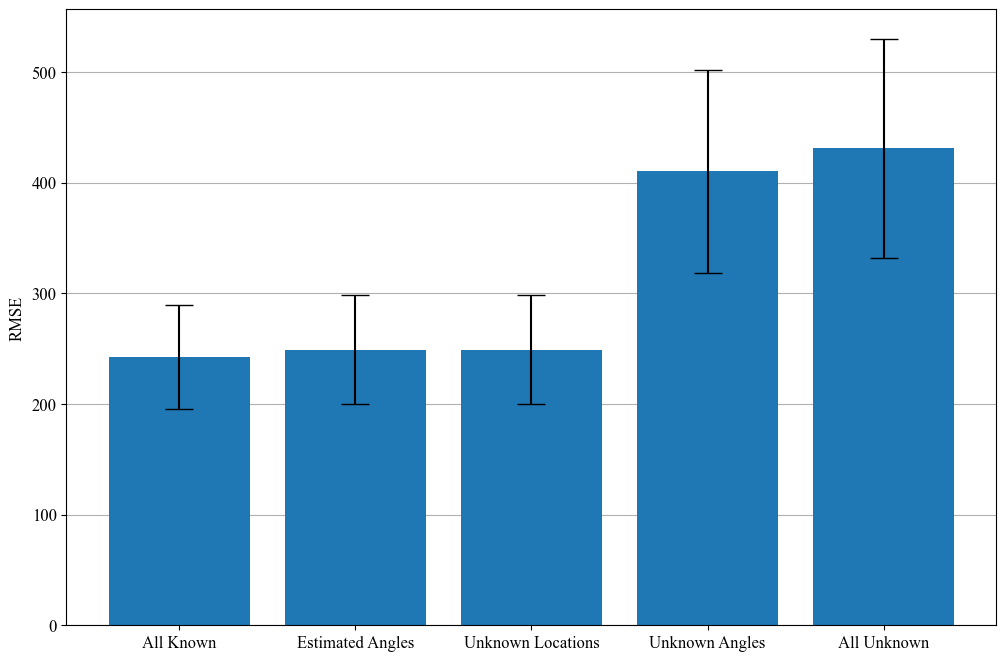

In [116]:
def acc_bar_plot(df_plot: pd.DataFrame, acc_name: str):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_axisbelow(True)
    ax.grid(axis = "y")
    ax.bar(x = df_plot.index, height = df_plot["mean"].values, yerr =df_plot["std"].values, capsize = 10)
    ax.set_ylabel(acc_name)



acc_bar_plot(df_plot_rmse, "RMSE")


# ML Modelling

1) Baseline Model = Aggregated Linear Regression

2) Quantity Analysis

3) Innovation: Shading extraction -> historic - physical; learn recurring, but moving shading -> superimpose this to physical profiles



In [214]:
#TODO choose a month with shading as testing set

def get_accuracies_per_month(df, model_type, metrics:list = None):

    accuracy_dictionary = {}

    start_date = df.index[0]
    test_begin = df.index[-1] - pd.Timedelta(days = 30)
    for month in range(1,12):
        train_end = start_date + pd.Timedelta(weeks = 4*month)

        assert train_end < test_begin, "Reduce the number of months, so a test period remains."
        train = df[start_date:train_end]

        test = df[test_begin:]


        scaler_ml_features = MinMaxScaler()
        scaler_ml_target = MinMaxScaler()

        X_train, y_train = scaler_ml_features.fit_transform(train.iloc[:,1:]), scaler_ml_target.fit_transform(train.iloc[:,:1])
        X_test, y_test = scaler_ml_features.transform(test.iloc[:,1:]), scaler_ml_target.transform(test.iloc[:,:1])


        model = model_type()
        model.fit(X = X_train, y = y_train)
        predictions = model.predict(X_test)

        gt_unscaled = scaler_ml_target.inverse_transform(y_test.reshape(-1,1))
        predictions_unscaled = scaler_ml_target.inverse_transform(predictions.reshape(-1,1))

        df_y_test = pd.DataFrame({"ground_truth":gt_unscaled.squeeze(), "predictions": predictions_unscaled.squeeze()}, index = test.index)

        rmse = mean_squared_error(y_true=df_y_test["ground_truth"], y_pred= df_y_test["predictions"], squared=False) / test.max()[0]
        r2 = r2_score(y_true=df_y_test["ground_truth"], y_pred= df_y_test["predictions"])

        accuracy_dictionary[month] = rmse, r2

    df_accuracy = pd.DataFrame(accuracy_dictionary, index = ["rmse", "r2"]).T

    return df_accuracy, df_y_test


In [215]:
rmse = []
r2 = []

for i in range(34):
    df_ml = pd.concat([df_power.iloc[:,i].to_frame("power_{}".format(i)), df_irr], axis = 1).dropna()
    x = get_accuracies_per_month(df_ml, LinearRegression)[0]
    rmse.append(x["rmse"])
    r2.append(x["r2"])





In [216]:
means_ml = pd.concat(rmse, axis = 1).mean(axis = 1)
std_ml = pd.concat(rmse, axis = 1).std(axis = 1)

df_stats_ml = pd.DataFrame({"mean": means_ml, "std": std_ml})

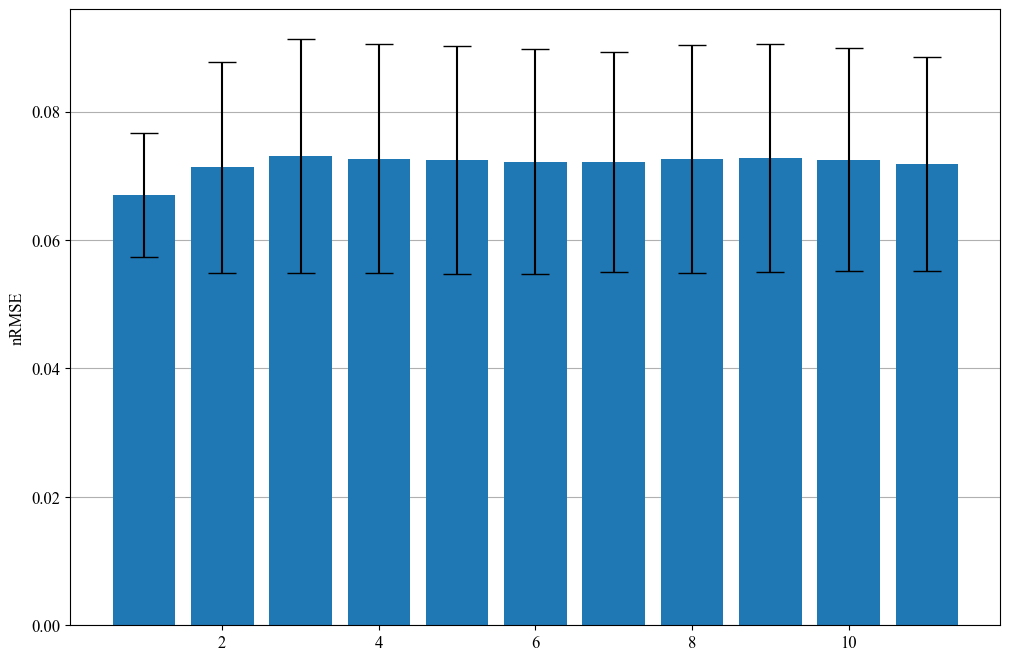

In [217]:




def acc_bar_plot(df_plot: pd.DataFrame, acc_name: str):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_axisbelow(True)
    ax.grid(axis = "y")
    ax.bar(x = df_plot.index, height = df_plot["mean"].values, yerr =df_plot["std"].values, capsize = 10)
    ax.set_ylabel(acc_name)


acc_bar_plot(df_stats_ml, "nRMSE")
